In [1]:
import joblib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

import os
os.chdir('../src')

from specs import m_to_label, downstream_scores, layer_map, assign_color
from plot_utils import make_correlation_plot, load_results, make_barplot, layerwise_rsa, plot_components

### Gather results

In [2]:
#Run this cell if not calculated yet...
results_df = load_results('../from_scratch')
results_df.to_csv('results.csv')

0it [00:04, ?it/s]


KeyboardInterrupt: 

In [2]:
#Else, just read the precalculated results
results_df = pd.read_csv('results.csv')

all_models_layer_rsa = []
for m in layer_map.keys():
    data = layerwise_rsa('../rdm_layerwise', m)
    data['rsa_b2021_max'] = max(data['lw_B2021']) if data['lw_B2021'] is not None else None
    data['rsa_nh2015_max'] = max(data['lw_NH2015']) if data['lw_NH2015'] is not None else None
    data['rsa_b2021_se'] = data['lw_std_B2021'][np.argmax(data['lw_B2021'])] if data['lw_B2021'] is not None else None
    data['rsa_nh2015_se'] = data['lw_std_NH2015'][np.argmax(data['lw_NH2015'])] if data['lw_NH2015'] is not None else None
    all_models_layer_rsa.append(data)

df_layerwise_rsa = pd.DataFrame(all_models_layer_rsa)
results_df = pd.merge(df_layerwise_rsa, results_df, left_on='model', right_on='model', how='right')

### Regression results

rsa_B2021_mean
rsa_B2021_se
rsa_NH2015_mean
rsa_NH2015_se


<Figure size 640x480 with 0 Axes>

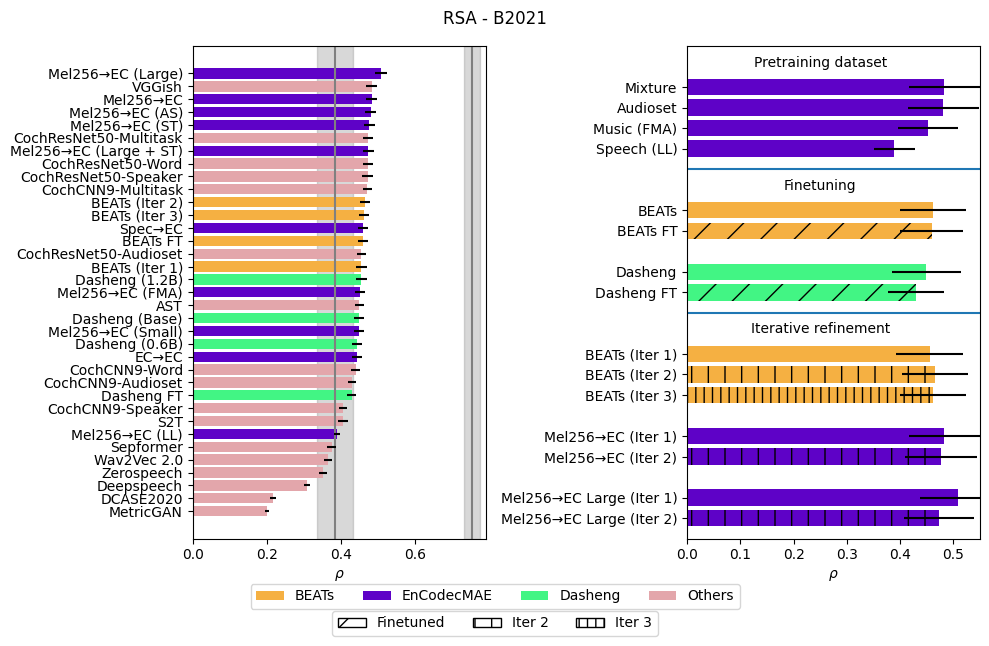

<Figure size 640x480 with 0 Axes>

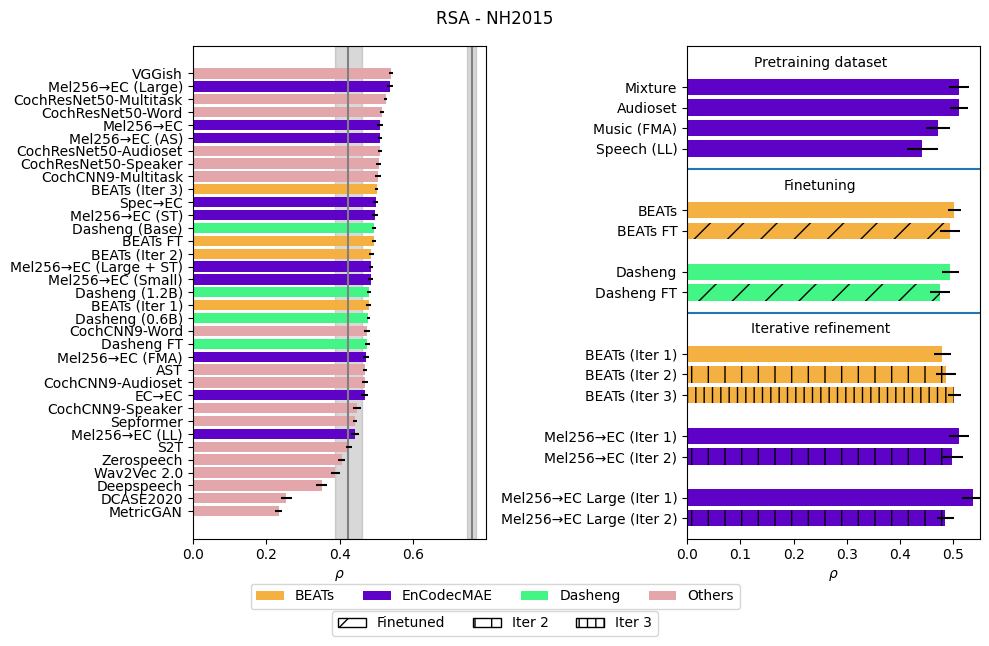

<Figure size 640x480 with 0 Axes>

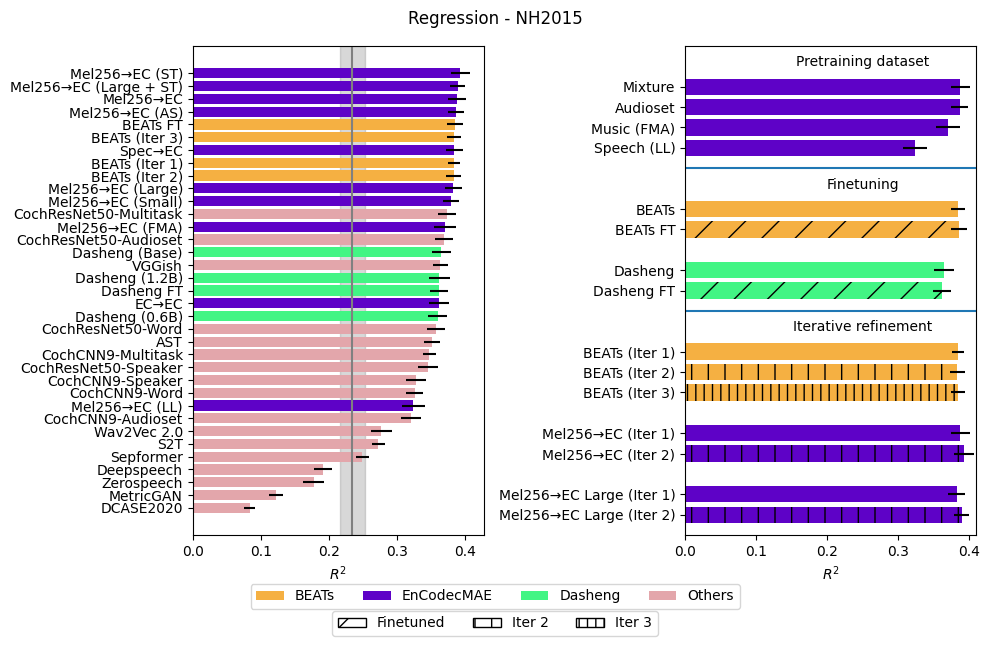

In [3]:
plt.figure()
make_barplot(results_df, 'rsa_b2021_max', xlabel=r'$\rho$')
plt.suptitle('RSA - B2021')
plt.tight_layout()
plt.savefig('rsa_b2021_lw.pdf', bbox_inches="tight")

plt.figure()
make_barplot(results_df, 'rsa_nh2015_max', xlabel=r'$\rho$')
plt.suptitle('RSA - NH2015')
plt.tight_layout()
plt.savefig('rsa_nh2015_lw.pdf', bbox_inches="tight")

plt.figure()
make_barplot(results_df, 'REG_NH2015_mean', topline=False, xlim=0.41)
plt.suptitle('Regression - NH2015')
plt.tight_layout()
plt.savefig('reg_nh2015.pdf', bbox_inches="tight")

### Per Layer RSA

Text(0, 0.5, '$\\rho$ - RDM Cross Validation')

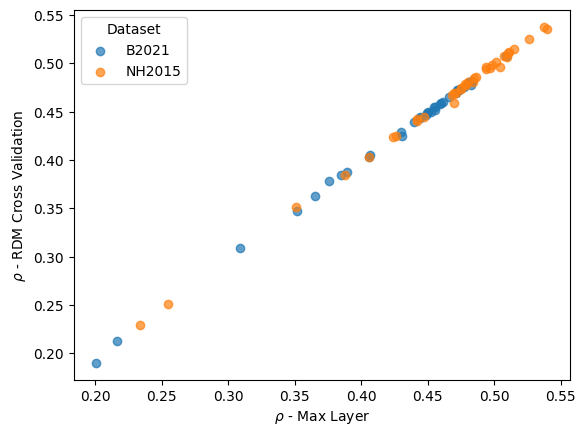

In [4]:
x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_B2021_mean'].values

x2 = results_df['rsa_nh2015_max'].values
y2 = results_df['rsa_NH2015_mean'].values

plt.scatter(x1, y1, alpha=0.7, label='B2021')
plt.scatter(x2, y2, alpha=0.7, label='NH2015')
plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.legend(title='Dataset')
plt.xlabel(r'$\rho$ - Max Layer')
plt.ylabel(r'$\rho$ - RDM Cross Validation')

### RSA vs Regression

Text(0, 0.5, '$\\rho$')

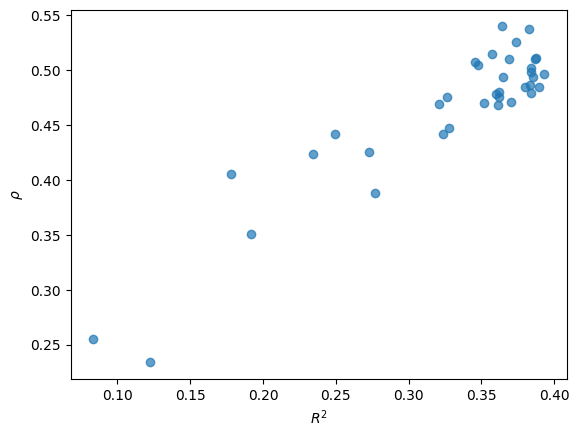

In [5]:
x1 = results_df['REG_NH2015_mean'].values
y1 = results_df['rsa_nh2015_max'].values


plt.scatter(x1, y1, alpha=0.7)
#plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.xlabel(r'$R^2$')
plt.ylabel(r'$\rho$')

Text(0, 0.5, '$\\rho - NH2015$')

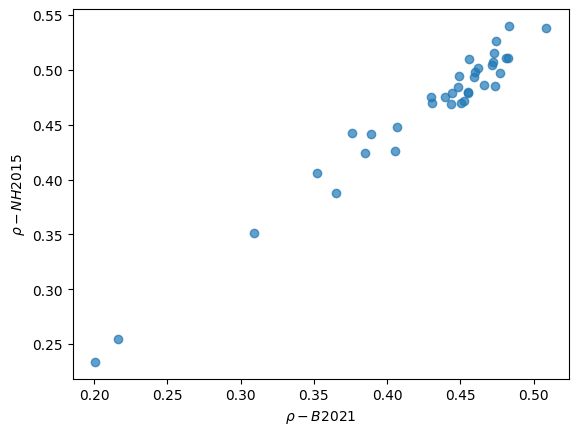

In [6]:
x1 = results_df['rsa_b2021_max'].values
y1 = results_df['rsa_nh2015_max'].values


plt.scatter(x1, y1, alpha=0.7)
#plt.plot(np.linspace(x1.min(), x1.max(), 20), np.linspace(x1.min(), x1.max(), 20), 'k--')

plt.xlabel(r'$\rho - B2021$')
plt.ylabel(r'$\rho - NH2015$')

### Components prediction

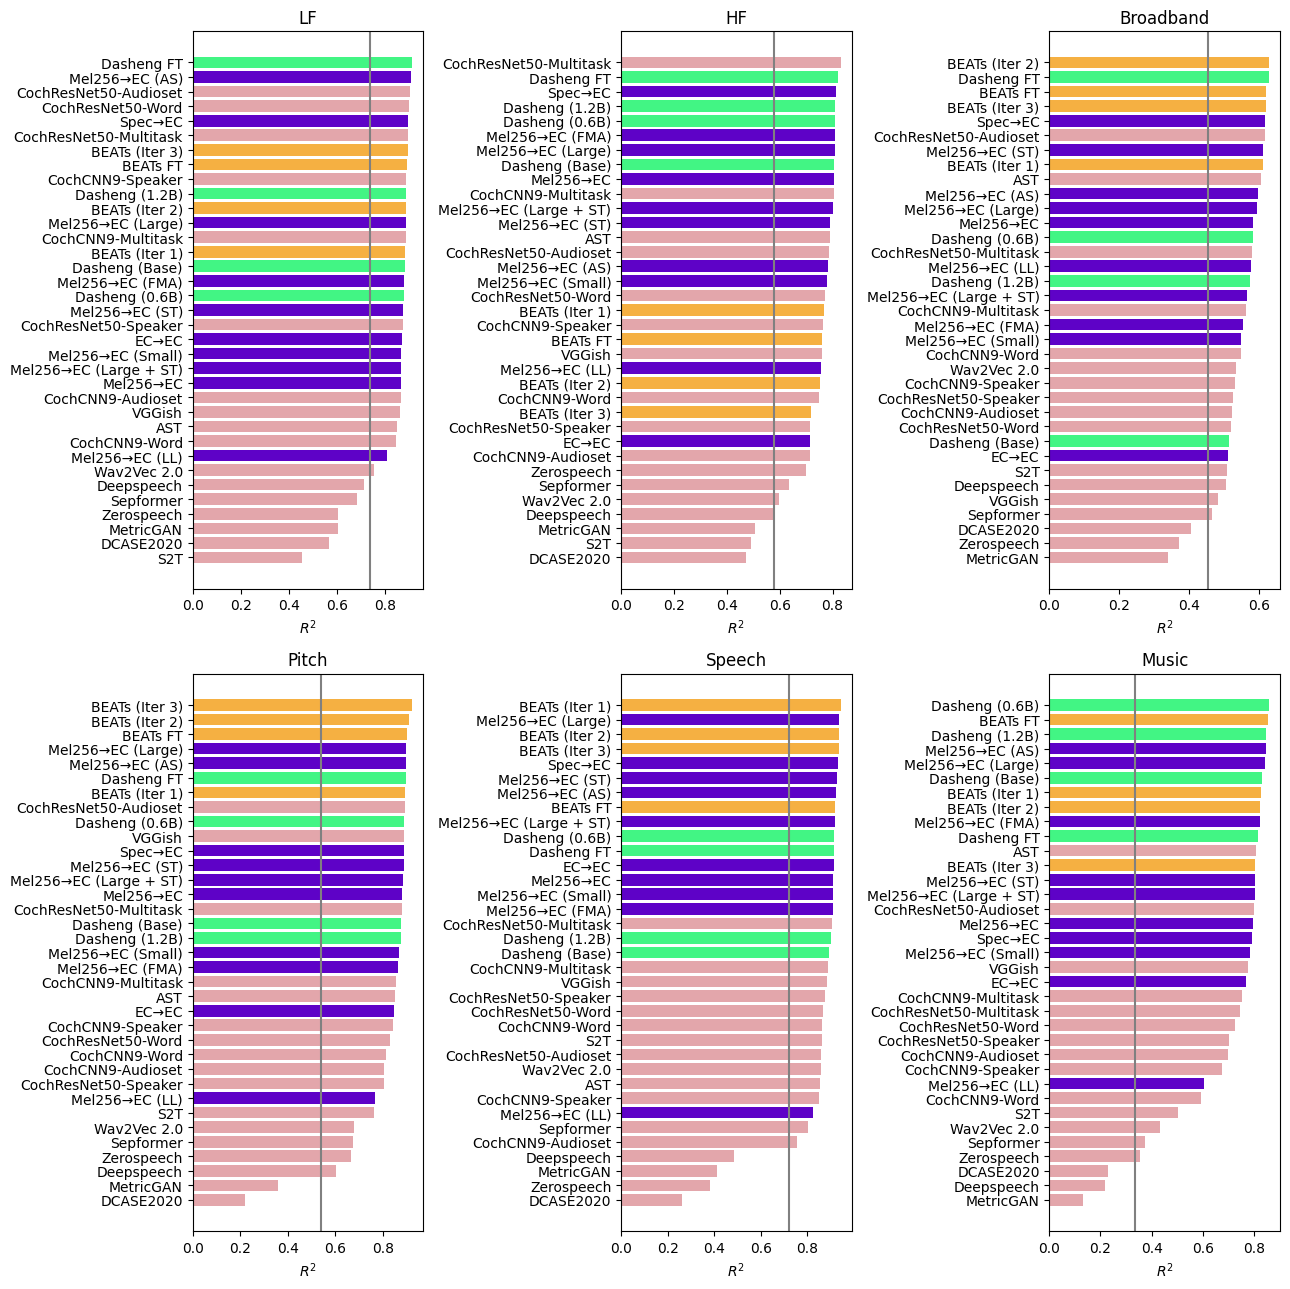

In [7]:
plot_components(results_df)
plt.savefig('components.pdf')

### Dynamics of alignment

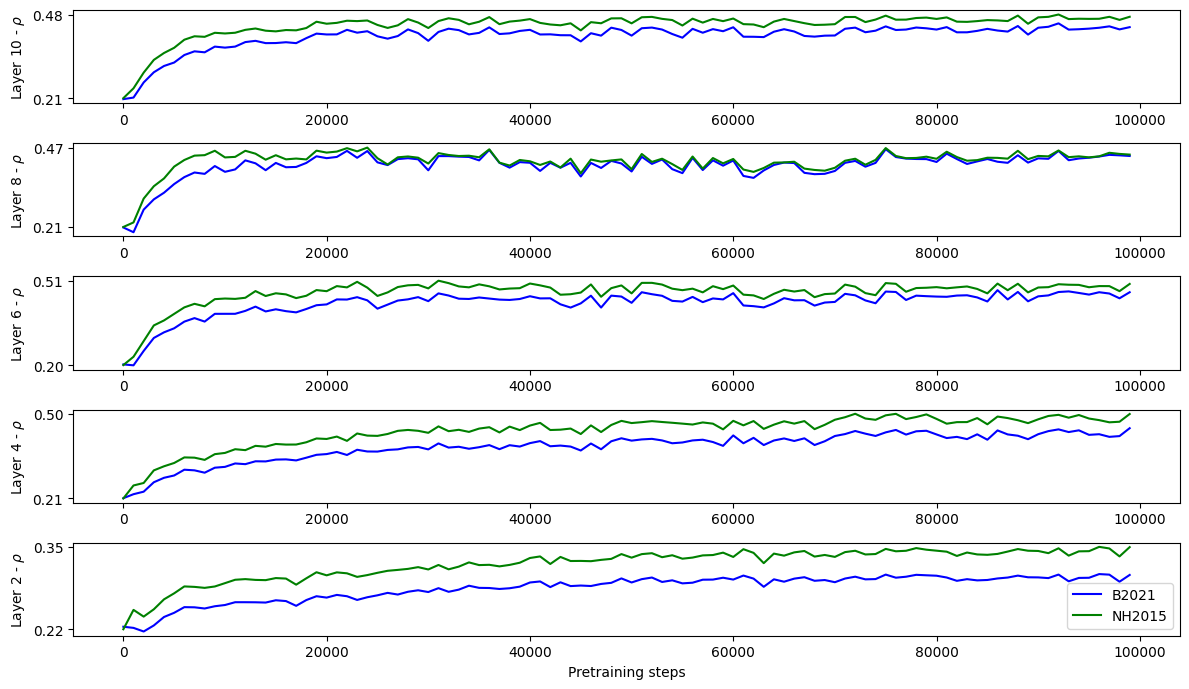

In [78]:
roi = ''
layers = [1,3,5,7,9]
fig, ax = plt.subplots(nrows=len(layers),figsize=(12,7))
for dataset in ['B2021', 'NH2015']:
    all_alignments = []
    for i in range(0,100000,1000):
        step_df = pd.DataFrame(joblib.load(f'../from_scratch/mel256-ec-base-dynamic/{i}/RSA_{dataset}{roi}.pkl')['subjects_r'])
        all_alignments.append(step_df.groupby('layer')['subj_r'].mean())
    all_layers_curves = []
    for l in layer_map['mel256-ec-base']:
        layer_l = [a.loc[l] for a in all_alignments]
        all_layers_curves.append(layer_l)
    if dataset == 'B2021':
        color = 'blue'
    elif dataset == 'NH2015':
        color = 'green'
    for i,l in enumerate(layers):
        layer_c = np.array(all_layers_curves)[l]
        ax[-i-1].plot(range(0,100000,1000),layer_c,c=color,label=dataset)
        ax[-i-1].set_yticks([layer_c.min(), layer_c.max()], [f'{xi:.2f}' for xi in [layer_c.min(), layer_c.max()]])
        ax[-i-1].set_ylabel(f'Layer {l+1} - $\\rho$')
        #ax[i].axhline(y=results_df.loc[results_df['model']=='braindnn_spectemp_filters']['rsa_{}_max'.format(dataset.lower())].values[0], c=color, linestyle='--')

plt.xlabel('Pretraining steps')
plt.legend()
plt.tight_layout()
plt.savefig('dynamics-layerwise.pdf')

In [94]:
np.array(layer_map['mel256-ec-base'])[[0,2]]

array(['mel256-ec-base_0', 'mel256-ec-base_2'], dtype='<U16')

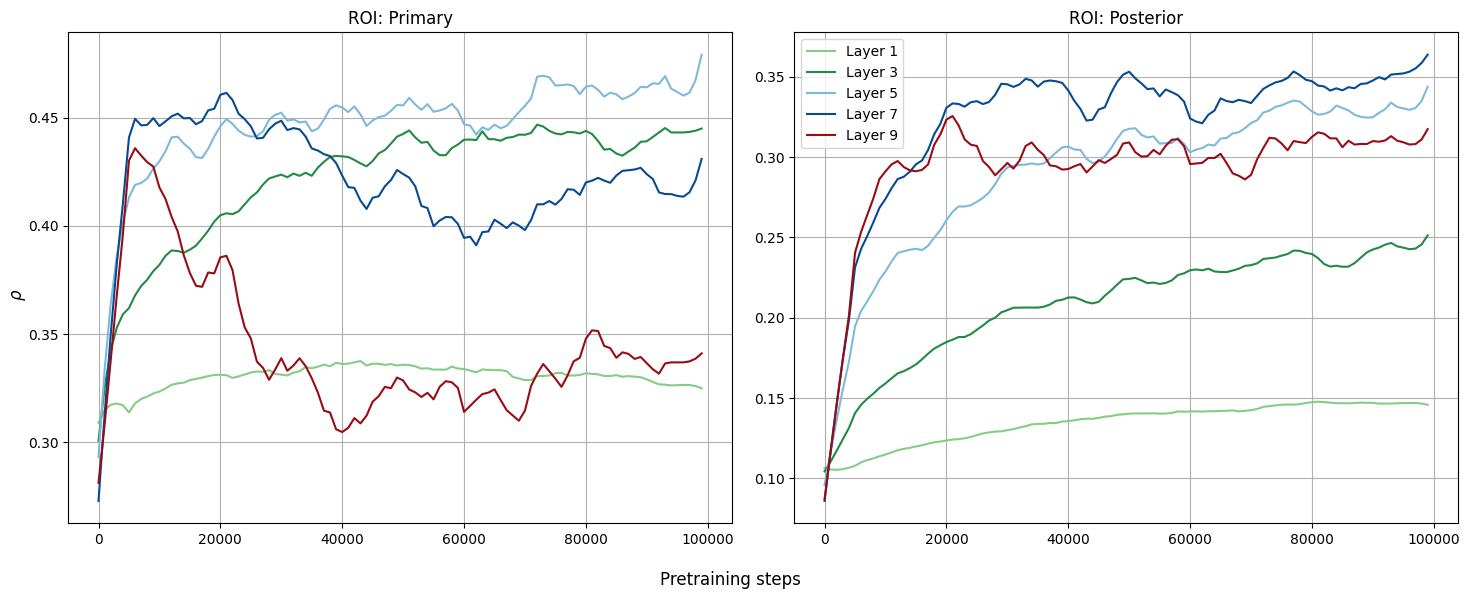

In [119]:
import matplotlib.cm as cm
from scipy.signal import savgol_filter

colors = [cm.Greens(0.45), cm.Greens(0.5), cm.Greens(0.75),cm.Greens(1.0),
          cm.Blues(0.45), cm.Blues(0.6), cm.Blues(0.9),
          cm.Reds(0.3), cm.Reds(0.9), cm.Reds(0.9)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
for axi, roi in enumerate(['Primary', 'Posterior']):
    all_alignments = []
    for i in range(0,100000,1000):
        step_df = pd.DataFrame(joblib.load(f'../from_scratch/mel256-ec-base-dynamic/{i}/RSA_NH2015{roi}.pkl')['subjects_r'])
        all_alignments.append(step_df.groupby('layer')['subj_r'].mean())
    all_layers_curves = []
    for l in np.array(layer_map['mel256-ec-base'])[[0,2,4,6,8]]:
        layer_l = [a.loc[l] for a in all_alignments]
        layer_l = savgol_filter(layer_l, window_length=10, polyorder=3)
        #all_layers_curves.append(layer_l)
        layer_i = int(l.split('_')[-1])
        ax[axi].plot(range(0,100000,1000), layer_l, color=colors[layer_i], label=f'Layer {layer_i + 1}')
        ax[axi].set_title(f'ROI: {roi}')
        ax[axi].grid('on')

fig.supxlabel('Pretraining steps')
fig.supylabel(r'$\rho$')
plt.tight_layout()
plt.legend()
plt.savefig('roi-rsa-layerwise-dynamic.pdf')

### Downstream vs Alignment

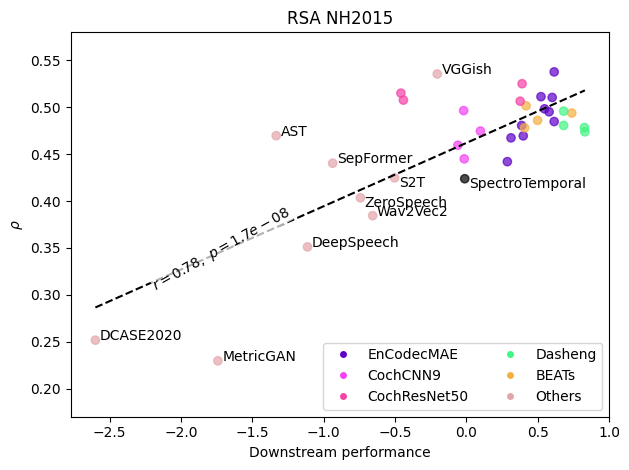

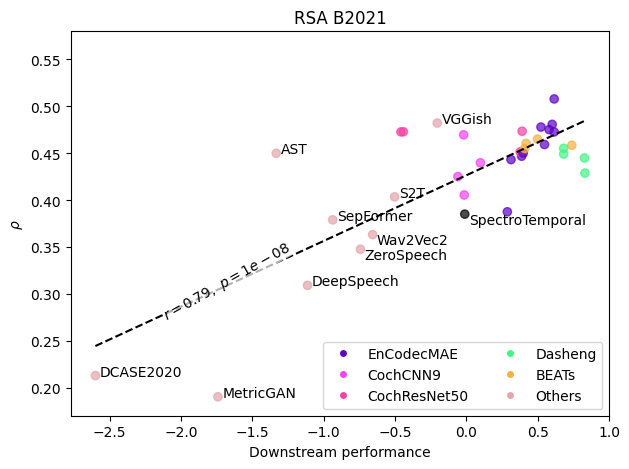

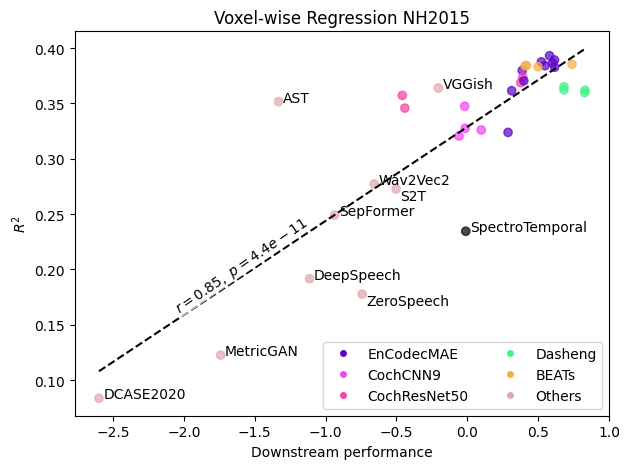

In [17]:
plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA NH2015')
plt.tight_layout()
plt.savefig('corr_rsa_nh2015.pdf')

plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'rsa_B2021_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$\\rho$')
plt.ylim(0.17,0.58)
plt.title('RSA B2021')
plt.tight_layout()
plt.savefig('corr_rsa_b2021.pdf')

plt.figure()
make_correlation_plot(results_df, 'DOWNSTREAM_global', 'REG_NH2015_mean', 
                      x_offset_pixels=-300,
                      y_offset_pixels=10,
                      xlabel='Downstream performance',
                      ylabel='$R^2$')
plt.title('Voxel-wise Regression NH2015')
plt.tight_layout()
plt.savefig('corr_reg_nh2015.pdf')

In [3]:
def get_layer_homogeneity(results_path, model, dataset='B2021'):
    rsa_path = Path(results_path, model, f'RSA_{dataset}.pkl')
    if rsa_path.exists():
        rsa_b2021 = joblib.load(rsa_path)
        n_layers = len(layer_map[model])
        distribution = np.zeros(n_layers)
        idxs, counts = np.unique(np.array(rsa_b2021['subjects_layer_selection']), return_counts=True)
        idxs = idxs.astype(int)
        distribution[idxs] = counts / np.sum(counts)
    
        return {'max_freq': np.max(distribution), 'unique': len(idxs)/n_layers}
    else:
        return None

dataset = 'B2021'
for model in layer_map:
    mf = get_layer_homogeneity('../rsa_corrected', model, dataset=dataset)
    if mf is not None:
        mff = mf['max_freq']
        un = mf['unique']
        rsa_val = results_df.loc[results_df['model'] == model][f'rsa_{dataset}_mean'].values[0]
        print(f'{model}: MaxFreq: {mff:.3f} - Unique: {un} - RSA: {rsa_val:.3f}')

NameError: name 'results_df' is not defined